In [0]:
# Check GPU enable on Colab
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   1823      0 --:--:-- --:--:-- --:--:--  1823
Updating fastai...
Done.


# Tabular models

In [0]:
# Import
from fastai.tabular import *

## Processing tabular data

In [0]:
path = untar_data(URLs.ADULT_SAMPLE)

In [0]:
path.ls()

[PosixPath('/content/data/adult_sample/adult.csv'),
 PosixPath('/content/data/adult_sample/models'),
 PosixPath('/content/data/adult_sample/export.pkl')]

In [0]:
df = pd.read_csv(path/"adult.csv")

In [0]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


### Define Categorical variables, Continuous variables, and Dependent variable

* Categorical variables will be replaced by a category - a unique id that identifies them - before they are passed through an embedding layer.

* Continuous variables will be normalized and then directly fed to the model.

* Dependent variable: will be label.

In [0]:
# Dependent variable
dep_var = "salary"

In [0]:
# Categorical variables
cat_names = ["workclass", "education", "marital-status", "occupation", "relationship", "race"]

In [0]:
# Continuous variables
cont_names = ["age", "fnlwgt", "education-num"]

### Processing the missing values

In [0]:
procs_missing = [FillMissing, Categorify, Normalize]

In [0]:
test = TabularList.from_df(df=df.iloc[800:1000].copy(), 
                           path=path, 
                           cat_names=cat_names, 
                           cont_names=cont_names)

In [0]:
test[:2]

TabularList (2 items)
age                               45
workclass                    Private
fnlwgt                         96975
education               Some-college
education-num                    NaN
marital-status              Divorced
occupation         Handlers-cleaners
relationship               Unmarried
race                           White
sex                           Female
capital-gain                       0
capital-loss                       0
hours-per-week                    40
native-country         United-States
salary                          <50k
Name: 800, dtype: object,age                                46
workclass                Self-emp-inc
fnlwgt                         192779
education                 Prof-school
education-num                     NaN
marital-status     Married-civ-spouse
occupation             Prof-specialty
relationship                  Husband
race                            White
sex                              Male
capital-gain      

In [0]:
data = (TabularList.from_df(df=df, 
                            path=path, 
                            cat_names=cat_names, 
                            cont_names=cont_names, 
                            procs=procs_missing)
        .split_by_idx(list(range(800,1000)))
        .label_from_df(cols=dep_var)
        .add_test(test)
        .databunch())

In [0]:
# Display categorcial and continuous variables
print("Categorical variable: {}".format(data.train_ds.cat_names))
print("Continuous variables: {}".format(data.train_ds.cont_names))

Categorical variable: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'education-num_na']
Continuous variables: ['age', 'fnlwgt', 'education-num']


In [0]:
data.show_batch(rows=10)

workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,target
Self-emp-not-inc,5th-6th,Married-civ-spouse,Transport-moving,Husband,White,False,0.6166,-0.3505,-2.7692,<50k
State-gov,Prof-school,Married-civ-spouse,Exec-managerial,Husband,White,False,0.5434,0.5793,1.9245,>=50k
Private,HS-grad,Divorced,Machine-op-inspct,Not-in-family,White,False,0.3235,-1.0040,-0.4224,<50k
Private,Some-college,Married-civ-spouse,Sales,Husband,White,False,0.2502,0.1029,-0.0312,<50k
Private,Assoc-voc,Married-civ-spouse,Machine-op-inspct,Husband,White,False,-0.0430,-0.7520,0.3599,<50k
Private,HS-grad,Married-spouse-absent,Adm-clerical,Not-in-family,White,False,3.0355,0.1210,-0.4224,<50k
Private,Assoc-voc,Married-civ-spouse,Other-service,Husband,White,False,0.6166,0.8188,0.3599,<50k
Private,7th-8th,Married-civ-spouse,Exec-managerial,Husband,White,False,0.1769,-1.5071,-2.3781,<50k
Private,11th,Never-married,Other-service,Own-child,White,False,-1.5090,-1.3691,-1.2046,<50k
State-gov,Masters,Married-civ-spouse,Prof-specialty,Husband,White,False,0.3968,-1.4796,1.5334,>=50k


## Build model

In [0]:
learn = tabular_learner(data, 
                        layers=[200, 100],
                        metrics=accuracy)

In [0]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(7, 5)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=42, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU(inplace)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [0]:
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.370017,0.404684,0.775000,00:07


In [0]:
learn.save("stage-1")

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


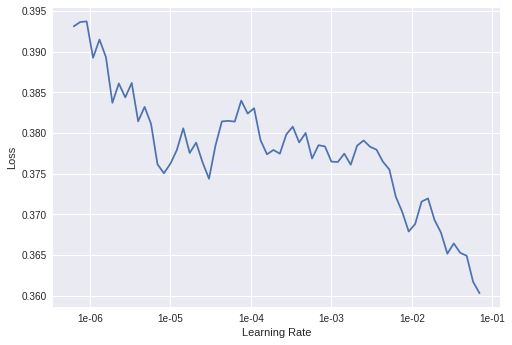

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.show_results()

workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,target,prediction
Private,Some-college,Divorced,Handlers-cleaners,Unmarried,White,True,0.4701,-0.8793,-0.0312,<50k,<50k
Self-emp-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,True,0.5434,0.0290,-0.0312,>=50k,>=50k
Private,Assoc-voc,Divorced,#na#,Not-in-family,White,True,-0.1896,1.7704,-0.0312,<50k,<50k
Federal-gov,Bachelors,Never-married,Tech-support,Not-in-family,White,True,-0.9959,-1.3242,-0.0312,<50k,<50k
Private,Bachelors,Married-civ-spouse,#na#,Husband,White,True,-0.1163,-0.2389,-0.0312,<50k,>=50k


In [0]:
samples = TabularList.from_df(df=df.iloc[800:1000].copy(), 
                           path=path, 
                           cat_names=cat_names, 
                           cont_names=cont_names)

In [0]:
for s in samples[:20]:
    print("User attributes:")
    print(s)
    print()
    print("Preduct result:")
    print(learn.predict(s))
    print("=========================================\n")

User attributes:
age                               45
workclass                    Private
fnlwgt                         96975
education               Some-college
education-num                    NaN
marital-status              Divorced
occupation         Handlers-cleaners
relationship               Unmarried
race                           White
sex                           Female
capital-gain                       0
capital-loss                       0
hours-per-week                    40
native-country         United-States
salary                          <50k
Name: 800, dtype: object

Preduct result:
(Category <50k, tensor(0), tensor([0.9291, 0.0709]))

User attributes:
age                                46
workclass                Self-emp-inc
fnlwgt                         192779
education                 Prof-school
education-num                     NaN
marital-status     Married-civ-spouse
occupation             Prof-specialty
relationship                  Husband
race       